<a href="https://colab.research.google.com/github/Molten-Ice/3dGolfPoseDetection/blob/colab/dev-nbs/17-worst-predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon May  1 11:37:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
test_name = '1k_rotation_unfrozen_fpn'

In [ ]:
!tensorboard dev export --outdir tensorboard_experiments

2023-04-30 23:03:59.516523: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-30 23:03:59.572706: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 23:04:00.399865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will download all your experiment data from https://tensorboard.dev
and save it to the following directory:

tensorboard_experiments

service. All experiments uploaded to TensorBoard.dev are publicly
visible. D

In [ ]:
import os
import json

project = 'golf2d'
most_recent_foldername = None
run_idx = 0
for foldername in os.listdir('tensorboard_experiments'):
    metadata_path = f'tensorboard_experiments/{foldername}/metadata.json'
    with open(metadata_path) as f:
        metadata = json.load(f)
    if metadata['name'].split('_')[0] == project:
        found_run_idx = int(metadata['name'].split('_')[1])
        if found_run_idx >= run_idx:
            run_idx = found_run_idx
            most_recent_foldername = foldername
            print(f"Most recent experiment: {metadata['name']} | {foldername}")

run_idx+=1
print(f"Starting on run_idx: {run_idx}")

Most recent experiment: golf2d_1_original_1k | experiment_88HJ8JFdSqGjYg7Y8GLIag
Most recent experiment: golf2d_4_1k_unfrozen_fpn | experiment_D5b4qYXWSPmA64dDrVOyZA
Starting on run_idx: 5


In [ ]:
%load_ext tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter
#put grip, first e.g. grip_test, head_test, to make the graphs so in the right oder
layout = {
    "ABCDE": {
        "accuracy": ["Multiline", ["accuracy/bbox", "accuracy/grip", "accuracy/head"]],
        "losses" : ["Multiline", ["losses/loss_keypoint", "losses/loss_classifier", "losses/loss_objectness", "losses/loss_box_reg", "losses/loss_rpn_box_reg"]],
        "hyperparameters": ["Multiline", ["hyperparameters/lrs"]],
    },
}

test_name = f'{run_idx}_{test_name}'

# default `log_dir` is "runs" - we'll be more specific here
writer_train = SummaryWriter(f'runs/{test_name}/train')
writer_test = SummaryWriter(f'runs/{test_name}/test')
writer_train.add_custom_scalars(layout)
writer_test.add_custom_scalars(layout)
print(f"Saving to: 'runs/{test_name}/train'")
print(f"Saving to: 'runs/{test_name}/test'")

Saving to: 'runs/5_1k_rotation_unfrozen_fpn/train'
Saving to: 'runs/5_1k_rotation_unfrozen_fpn/test'


In [2]:
import torch
import torchvision
import torch.nn as nn
import albumentations as A # Library for augmentations
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

import os
import cv2
import json
import time
import shutil
import random
import argparse
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps


# repo_dir = "c:/Users/James/git/3dGolfPoseDetection/"
# repo_dir = "/home/fsuser/3dGolfPoseDetection/"
repo_dir = "/content/"
data_path = repo_dir + "downloaded-data/"

if not os.path.exists(data_path): 
    print("Creating folder: ", data_path)
    os.mkdir(data_path)

Creating folder:  /content/downloaded-data/


In [3]:
### Download data from kaggle on google colab) ###

import json
import zipfile
kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

if not os.path.exists('/root/.kaggle'): os.mkdir('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_apikey, f)

! chmod 600 ~/.kaggle/kaggle.json

!kaggle config set -n path -v {data_path}

## Download and unzip data ##

! kaggle datasets download jamesdavey/labelled-golf-clubs
zip_path = data_path+"datasets/jamesdavey/labelled-golf-clubs/labelled-golf-clubs.zip"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(data_path)

- path is now set to: /content/downloaded-data/
100% 670M/671M [00:40<00:00, 20.6MB/s]
100% 671M/671M [00:40<00:00, 17.4MB/s]


In [4]:
class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, save_dir, filenames, annotate = False, padding = False, augment = False):
        self.save_dir = save_dir
        self.filenames = filenames
        self.annotate = annotate
        self.img_transforms = transforms.ToTensor()
        self.padding = padding
        self.augment = augment

        self.max_augmentation_attempts = 10
        self.albumentations_transform = A.Compose(
            [A.HorizontalFlip(p=0.5),
             A.VerticalFlip(p=0.2),
             A.Rotate(p=0.3)],
            keypoint_params=A.KeypointParams(format='xy'))
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img = cv2.imread(self.save_dir+filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cords = [int(x) for x in filename.split("_")[1].split("-")]
        grip, head = cords[:2], cords[2:]

        if self.augment:
            for i in range(self.max_augmentation_attempts): # 10 attempts to crop keypoints within, otherwise use original img
                transformed = self.albumentations_transform(image=img, keypoints=[grip, head])
                if len(transformed['keypoints']) == 2: # keypoint has not been cropped out
                    # print(f"Both keypoints found, after {i} tries")
                    img = transformed['image']
                    grip, head = transformed['keypoints']
                    break
            grip, head = [int(x) for x in grip], [int(x) for x in head]

        box_buffer = max(img.shape[:2])//20
        box_cords = [
            max(min(grip[0], head[0])-box_buffer, 1),
            max(min(grip[1], head[1])-box_buffer, 1), #top left cord
            min(max(grip[0], head[0])+box_buffer, img.shape[1]-1), # shape[0] is y
            min(max(grip[1], head[1])+box_buffer, img.shape[0]-1)] # bottom right cord

        if self.annotate:
            cv2.circle(img, grip, 8, (0,255,0), -1)
            cv2.circle(img, head, 8, (0,255,255), -1)
            cv2.line(img, head, grip, (0, 0, 255), 2)
            cv2.rectangle(img, box_cords[:2], box_cords[2:], (255, 0, 0), 4)

        if self.padding:
            max_height, max_width = 720, 1225
            height, width = img.shape[:2]
            img = cv2.copyMakeBorder(img, 0, max_height-height, 0, max_width-width, cv2.BORDER_CONSTANT)

        # During training, the model expects both the input tensors and targets (list of dictionary), containing:
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
        # labels (Int64Tensor[N]): the class label for each ground-truth box
        # keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.
        target = {}
        target["boxes"] = torch.Tensor(box_cords).unsqueeze(dim=0).type(torch.FloatTensor)
        target["labels"] = torch.Tensor(torch.ones(1)).type(torch.int64)
        target["keypoints"] = torch.Tensor([grip + [1.], head + [1.]]).unsqueeze(dim=0).type(torch.FloatTensor)

        img = Image.fromarray(img)
        img = self.img_transforms(img)
        return img, target
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [13]:
### Functions to visualize dataset and predictions ###

def tensor_to_pil(tensor_img):
    return (tensor_img*255).permute(1,2,0).cpu().numpy().astype(np.uint8)

def pad_img(cv2_image):
    max_height, max_width = 720, 1225
    height, width = cv2_image.shape[:2]
    return cv2.copyMakeBorder(cv2_image, 0, max_height-height, 0, max_width-width, cv2.BORDER_CONSTANT)

def label_img(img, labels):
    box = [int(x) for x in labels['boxes'][0]]
    grip = [int(x) for x in labels['keypoints'][0, 0, :2]]
    head = [int(x) for x in labels['keypoints'][0, 1, :2]]
    cv2.rectangle(img, box[:2], box[2:], (255,0,0), 3)
    cv2.circle(img, grip, 5, (255, 0, 255), -1)
    cv2.circle(img, head, 5, (255, 0, 255), -1)
    cv2.line(img, head, grip, (0, 255, 0), 2)
    return img

def generate_grid_from_pil(images, hor_width):

    #Filling it out with blank images to make a square
    for i in range(hor_width - len(images) // 3):
        images.append(np.zeros_like(images[0]))

    #Create image grid
    rows = []
    for row_idx in range(len(images) // hor_width):
        rows.append(np.concatenate(images[row_idx*hor_width: (row_idx+1)*hor_width], axis=1))
    img_grid = np.concatenate(rows, axis=0)

    return img_grid

def generate_grid_dataset(input_images, labels, hor_width = 4, label = True):
    images = []
    for tensor_img, labels in zip(input_images, labels):
        img = pad_img(tensor_to_pil(tensor_img))
        if label:
            img = label_img(img, labels)

        images.append(img)

    img_grid = generate_grid_from_pil(images, hor_width)

    return img_grid

def generate_grid_predictions(model, dataloader, imgs_to_generate = 12, hor_width = 4):
    display_images = []
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            if len(display_images) >= imgs_to_generate:
                break
            preds = model([img.to(device) for img in batch[0]])
            for tensor_img, pred_labels in zip(batch[0], preds):
                img = pad_img(tensor_to_pil(tensor_img))
                try:
                    img = label_img(img, pred_labels)
                    display_images.append(img)
                except Exception as e:
                    print(f"Skipping at img {len(display_images)} | {e}")
                if len(display_images) >= imgs_to_generate:
                    print(f"{len(display_images)} images generated")
                break
    img_preds_grid = generate_grid_from_pil(display_images, hor_width)
    return img_preds_grid

In [6]:
def evaluate_model(model, dataloader):
    box_diffs = []
    keypoint_diffs = []
    total_elements = 0

    t_start = time.time()
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            images = [img.to(device) for img in batch[0]]
            targets = [{key: d[key].to(device) for key in d.keys()} for d in batch[1]]
            preds = model(images)

            total_elements+=len(preds)
            for idx in range(len(preds)):
                predicted_boxes = preds[idx]['boxes']
                predicted_clubs = preds[idx]['keypoints']
                if len(predicted_boxes) > 0:
                    real_box = targets[idx]['boxes'][0]
                    box_diffs.append(torch.abs(predicted_boxes[0] - real_box))

                if len(predicted_clubs) > 0:
                    real_keypoints = targets[idx]['keypoints'][0]
                    keypoint_diffs.append(torch.abs(predicted_clubs[0] - real_keypoints)[:,:2])
    model.train()

    if len(box_diffs) == 0:
        average_box_diff = []
        boxes_predicted = 0
    else:
        stacked_boxes = torch.stack(box_diffs,dim=0).cpu().numpy()
        average_box_diff = np.mean(stacked_boxes, axis=0)
        boxes_predicted = stacked_boxes.shape[0]

    if len(keypoint_diffs) == 0:
        average_keypoint_diff = [[], []]
        keypoints_predicted = 0
    else:
        stacked_keypoints = torch.stack(keypoint_diffs,dim=0).cpu().numpy() #[[(x_grip, y_grip), (x_club, y_club)],...]
        average_keypoint_diff = np.mean(stacked_keypoints, axis=0)
        keypoints_predicted = stacked_keypoints.shape[0]

    return average_box_diff, average_keypoint_diff, total_elements, boxes_predicted, keypoints_predicted, time.time()-t_start

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
out = nn.ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
model.roi_heads.keypoint_predictor.kps_score_lowres = out
model = model.to(device)

#freeze parameters in backbone
# for param in model.backbone.parameters():
for param in model.backbone.body.parameters():
    param.requires_grad = False

# f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
# 59,014,363
# 32,215,067
# 35,559,451 unfrozen fpn

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:00<00:00, 305MB/s]


In [7]:
batch_size = 8

images_dir = data_path + "saved-labels/"
filenames = sorted(os.listdir(images_dir))

train_test_split = 0.8
split_index = int(len(filenames)*train_test_split)
train_filenames, test_filenames = filenames[:split_index], filenames[split_index:]

train_dataset = GolfDataset(images_dir, train_filenames, annotate = False, padding = False, augment = True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)

test_dataset = GolfDataset(images_dir, test_filenames, annotate = False, padding = False, augment = False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)

#note len(train_dataloader) > 1 otherwise % breaks
print(f"Dataset lengths | train {len(train_dataset)}, test {len(test_dataset)}")
print(f"Dataloader #batches | train {len(train_dataloader)}, test {len(test_dataloader)}, batches of size {batch_size}")

Dataset lengths | train 800, test 200
Dataloader #batches | train 100, test 25, batches of size 8


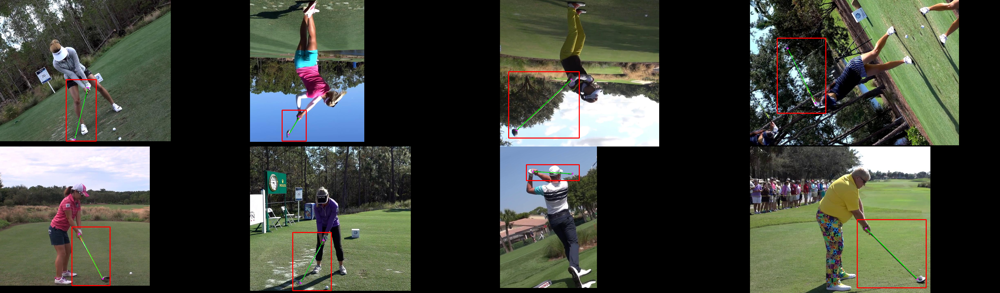

In [8]:
display(ImageOps.contain(Image.fromarray(generate_grid_dataset(*next(iter(train_dataloader)), hor_width=4, label = True)), (1000, 1000)))

In [ ]:
### Hyperparameters ###

epochs = 15
lr = 3e-4
eval_interval = 3

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr)
lr_scheduler_epochs = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

# Starting evaluation
# for split, dataloader in zip(["train", "test","train_clean"], [train_dataloader, test_dataloader, train_dataloader_clean]):
for split, dataloader, writer in zip(["train", "test"], [train_dataloader, test_dataloader], [writer_train, writer_test]):
    average_box_diff, average_keypoint_diff, total_elements, boxes_predicted, clubs_predicted, time_taken = evaluate_model(model, dataloader)
    print(f"{split} Evaluation | bbox: {average_box_diff.mean():.2f}, grip: {average_keypoint_diff[0].mean():.2f}, head: {average_keypoint_diff[1].mean():.2f} | bbox: [{boxes_predicted}/{total_elements}], keypoints: [{clubs_predicted}/{total_elements}], Time taken: {time_taken:.2f}s")
    writer.add_scalar("accuracy/bbox", average_box_diff.mean(), 0)
    writer.add_scalar("accuracy/grip", average_keypoint_diff[0].mean(), 0)
    writer.add_scalar("accuracy/head", average_keypoint_diff[1].mean(), 0)

### Training loop ###

training_iteration = 0
t_start = time.time()
model.train()
for epoch in range(epochs):
    print(f"--------- EPOCH {epoch} ---------")
    if epoch == 0: # learning rate warmup
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(train_dataloader) - 1)
        lr_scheduler_warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)

    for batch_idx, batch in enumerate(train_dataloader):

        

        images = [img.to(device) for img in batch[0]]
        targets = [{key: d[key].to(device) for key in d.keys()} for d in batch[1]]

        losses_dict = model(images, targets)
        total_loss = sum([losses_dict[key] for key in losses_dict.keys()])
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if epoch == 0: # this REALLY should be before the first batch (but throws a warning if moved)
            lr_scheduler_warmup.step()
        writer_train.add_scalar("hyperparameters/lrs", optimizer.param_groups[0]['lr'], training_iteration)

        for key in losses_dict.keys():
            writer_train.add_scalar(f"losses/{key}", losses_dict[key].item(), training_iteration)

        training_iteration+=1

        if batch_idx % (len(train_dataloader)//2) == 0:
            print(f"Epoch [{epoch+1}/{epochs}], batch [{batch_idx+1}/{len(train_dataloader)}] | Total loss: {total_loss.item():.2f}, Time: {time.time()-t_start:.2f}s | {''.join([f'{key}: {losses_dict[key].item():.4f}, ' for key in losses_dict.keys()])}")

    lr_scheduler_epochs.step()

    if epoch % eval_interval == 0 or epoch+1 == epochs:   
        # for split, dataloader in zip(["train", "test","train_clean"], [train_dataloader, test_dataloader, train_dataloader_clean]):
        for split, dataloader, writer in zip(["train", "test"], [train_dataloader, test_dataloader], [writer_train, writer_test]):
            average_box_diff, average_keypoint_diff, total_elements, boxes_predicted, clubs_predicted, time_taken = evaluate_model(model, dataloader)
            print(f"{split} Evaluation | bbox: {average_box_diff.mean():.2f}, grip: {average_keypoint_diff[0].mean():.2f}, head: {average_keypoint_diff[1].mean():.2f} | bbox: [{boxes_predicted}/{total_elements}], keypoints: [{clubs_predicted}/{total_elements}], Time taken: {time_taken:.2f}s")
            writer.add_scalar("accuracy/bbox", average_box_diff.mean(), epoch + 1)
            writer.add_scalar("accuracy/grip", average_keypoint_diff[0].mean(), epoch + 1)
            writer.add_scalar("accuracy/head", average_keypoint_diff[1].mean(), epoch + 1)

print(f"Total time: {time.time()-t_start:.2f}s")
writer.close()

train Evaluation | bbox: 146.11, grip: 88.47, head: 195.43 | bbox: [800/800], keypoints: [800/800], Time taken: 39.65s
test Evaluation | bbox: 143.12, grip: 80.02, head: 193.69 | bbox: [200/200], keypoints: [200/200], Time taken: 8.28s
--------- EPOCH 0 ---------
Epoch [1/15], batch [1/100] | Total loss: 10.51, Time: 1.11s | loss_classifier: 0.1946, loss_box_reg: 0.0652, loss_keypoint: 10.1461, loss_objectness: 0.0978, loss_rpn_box_reg: 0.0040, 
Epoch [1/15], batch [51/100] | Total loss: 4.55, Time: 22.94s | loss_classifier: 0.0797, loss_box_reg: 0.0921, loss_keypoint: 4.3282, loss_objectness: 0.0407, loss_rpn_box_reg: 0.0114, 
train Evaluation | bbox: 70.76, grip: 37.57, head: 89.15 | bbox: [800/800], keypoints: [800/800], Time taken: 45.33s
test Evaluation | bbox: 65.66, grip: 21.94, head: 88.79 | bbox: [200/200], keypoints: [200/200], Time taken: 11.29s
--------- EPOCH 1 ---------
Epoch [2/15], batch [1/100] | Total loss: 4.09, Time: 101.36s | loss_classifier: 0.0887, loss_box_reg: 

In [ ]:
#Note initial accuracy predictions are different this time
# train Evaluation | bbox: 143.32, grip: 95.49, head: 181.66 | bbox: [800/800], keypoints: [800/800], Time taken: 39.31s
# test Evaluation | bbox: 143.12, grip: 102.43, head: 187.06 | bbox: [200/200], keypoints: [200/200], Time taken: 8.37s
# Make sense as last layer I create with random initial weights, also have added data augmentation.
# Starting value 143.12 for test bbox is identicial to before

In [ ]:
list(model.backbone.fpn.parameters())[0][:5, :5, 0, 0]

tensor([[ 0.0147,  0.0075, -0.0089,  0.0045,  0.0334],
        [ 0.0065,  0.0109,  0.0309,  0.0022, -0.0179],
        [-0.0015,  0.0156, -0.0176,  0.0074,  0.0072],
        [ 0.0054,  0.0039,  0.0031,  0.0047,  0.0023],
        [-0.0004,  0.0019,  0.0303,  0.0166,  0.0116]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
os.mkdir("models")
model_name = "model_1_unfrozen_fpn_rotation.pth"
torch.save(model.state_dict(), 'models/'+model_name)

shutil.make_archive("models-to-upload/zipped-models", 'zip', "models")

"""
{
  "title": "2dGolfModels-2",
  "id": "jamesdavey/2dGolfModels-2",
  "licenses": [{"name": "CC0-1.0"}],
   "resources": [
    {
      "path": "zipped-models.zip",
      "description": "Models in zip format!"
    }
   ]
}
"""

'\n{\n  "title": "2dGolfModels",\n  "id": "jamesdavey/2dGolfModels",\n  "licenses": [{"name": "CC0-1.0"}],\n   "resources": [\n    {\n      "path": "zipped-models.zip",\n      "description": "Models in zip format!"\n    }\n   ]\n}\n'

In [ ]:
!kaggle datasets init -p /content/models-to-upload

Data package template written to: /content/models-to-upload/dataset-metadata.json


In [ ]:
!kaggle datasets create -p /content/models-to-upload

Starting upload for file zipped-models.zip
100% 209M/209M [00:11<00:00, 18.6MB/s]
Upload successful: zipped-models.zip (209MB)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/jamesdavey/2dGolfModels


In [ ]:
torch.cuda.empty_cache()

In [ ]:
### plot all previous experiments for this project ###
if most_recent_foldername is not None:
    print("Loading previous runs")

    print(f"Starting on run_idx: {run_idx}")
    scalars_path = f'tensorboard_experiments/{most_recent_foldername}/scalars.json'
    scalars_data = []
    with open(scalars_path) as f:
        for line in f:
            scalars_data.append(json.loads(line))

    current_run = ''
    for row in scalars_data:
        if row['run'] != current_run:
            if current_run != '':
                writer.close()
            print(f"Starting new run: {row['run']}")
            current_run = row['run']
            writer = SummaryWriter(f"runs/{row['run']}")
            writer.add_custom_scalars(layout)

        for value, iteration, wall_time in zip(row['points']['values'], row['points']['steps'], row['points']['wall_times']):
            writer.add_scalar(row['tag'], value, iteration, walltime = wall_time)

writer.close()

Loading previous runs
Starting on run_idx: 5
Starting new run: 1_original_1k/test
Starting new run: 1_original_1k/train
Starting new run: 2_augmented_1k_flipped/test
Starting new run: 2_augmented_1k_flipped/train
Starting new run: 3_augmented_1k_affine/test
Starting new run: 3_augmented_1k_affine/train
Starting new run: 4_1k_unfrozen_fpn/test
Starting new run: 4_1k_unfrozen_fpn/train


In [ ]:
%tensorboard --logdir runs

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
# Run 1: epochs = 9, lr=e3-4, 1k images, no augmentation
# Run 2: epochs = 15, lr=e3-4, 1k images, [HorizontalFlip(p=0.5),A.VerticalFlip(p=0.2)]
# Run 3: epochs = 15, lr=e3-4, 1k images, [HorizontalFlip(p=0.5),A.VerticalFlip(p=0.2), A.Affine(p=0.3)]
# Run 4: epochs = 15, lr=e3-4, 1k images, [HorizontalFlip(p=0.5),A.VerticalFlip(p=0.2)], unfreeze FeaturePyramidNetwork
# Run 5: epochs = 15, lr=e3-4, 1k images, [HorizontalFlip(p=0.5),A.VerticalFlip(p=0.2), A.Rotate(p=0.3)], unfrozen FeaturePyramidNetwork


In [ ]:
save_name = f"{project}_{test_name}"

!tensorboard dev upload --logdir ./runs \
  --name {save_name} \
  --description "Uploading results" \
  --one_shot 

2023-04-30 23:26:04.259971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/efka9cNYR52rexBjeLmxLw/

[2023-04-30T23:26:06] Started scanning logdir.
[2023-04-30T23:26:23] Total uploaded: 41553 scalars, 0 tensors, 0 binary objects
[2023-04-30T23:26:23] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/efka9cNYR52rexBjeLmxLw/


16 images generated


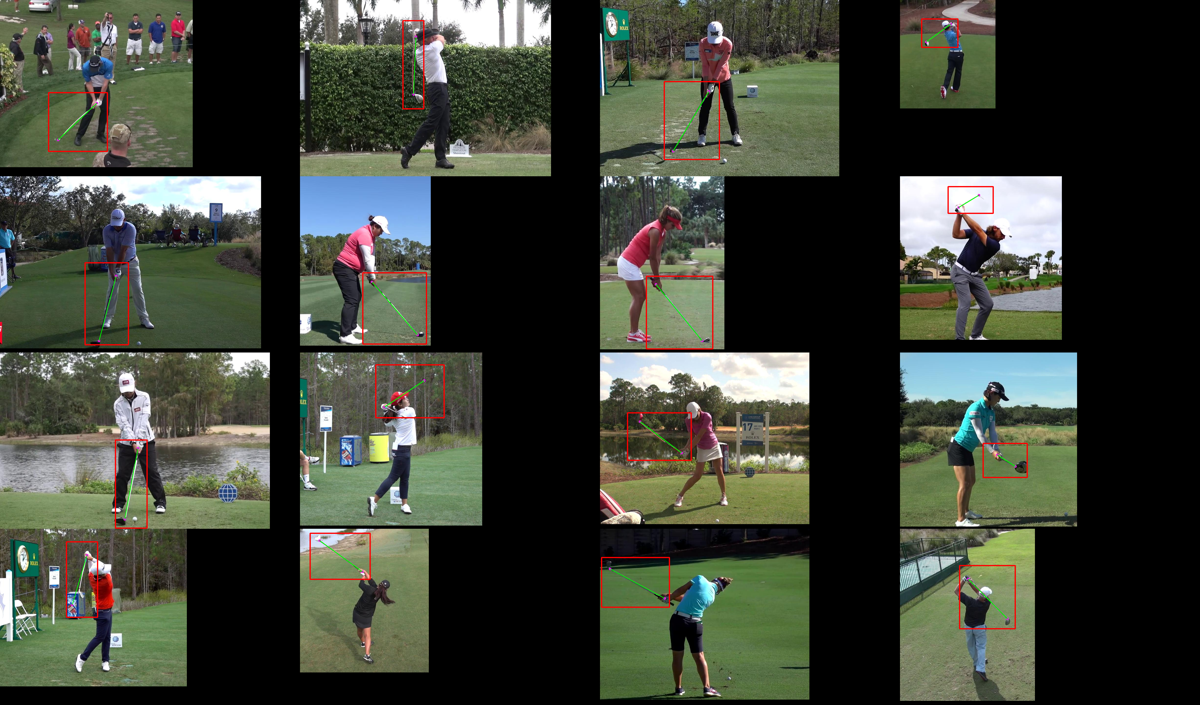

In [15]:
display(ImageOps.contain(Image.fromarray(generate_grid_predictions(model, test_dataloader, imgs_to_generate=16)), (1200, 1200)))

In [11]:
## Download and unzip  models ##
dataset_name = "2dgolfmodels"
model_name = "model_1_unfrozen_fpn_rotation.pth"
! kaggle datasets download jamesdavey/{dataset_name}
zip_path = data_path+f"datasets/jamesdavey/{dataset_name}/{dataset_name}.zip"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
    zip_ref.extractall(data_path)

device = 'cuda:0'
loaded_model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
loaded_model.eval()
out = nn.ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
loaded_model.roi_heads.keypoint_predictor.kps_score_lowres = out
loaded_model.load_state_dict(torch.load('downloaded-data/'+model_name))
loaded_model = loaded_model.to(device)
loaded_model.eval()
list(loaded_model.backbone.fpn.parameters())[0][:5, :5, 0, 0]

2dgolfmodels.zip: Skipping, found more recently modified local copy (use --force to force download)


tensor([[ 0.0147,  0.0075, -0.0089,  0.0045,  0.0334],
        [ 0.0065,  0.0109,  0.0309,  0.0022, -0.0179],
        [-0.0015,  0.0156, -0.0176,  0.0074,  0.0072],
        [ 0.0054,  0.0039,  0.0031,  0.0047,  0.0023],
        [-0.0004,  0.0019,  0.0303,  0.0166,  0.0116]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
for split, dataloader, writer in zip(["train", "test"], [train_dataloader, test_dataloader], [writer_train, writer_test]):
    average_box_diff, average_keypoint_diff, total_elements, boxes_predicted, clubs_predicted, time_taken = evaluate_model(loaded_model, dataloader)
    print(f"{split} Evaluation | bbox: {average_box_diff.mean():.2f}, grip: {average_keypoint_diff[0].mean():.2f}, head: {average_keypoint_diff[1].mean():.2f} | bbox: [{boxes_predicted}/{total_elements}], keypoints: [{clubs_predicted}/{total_elements}], Time taken: {time_taken:.2f}s")

16 images generated


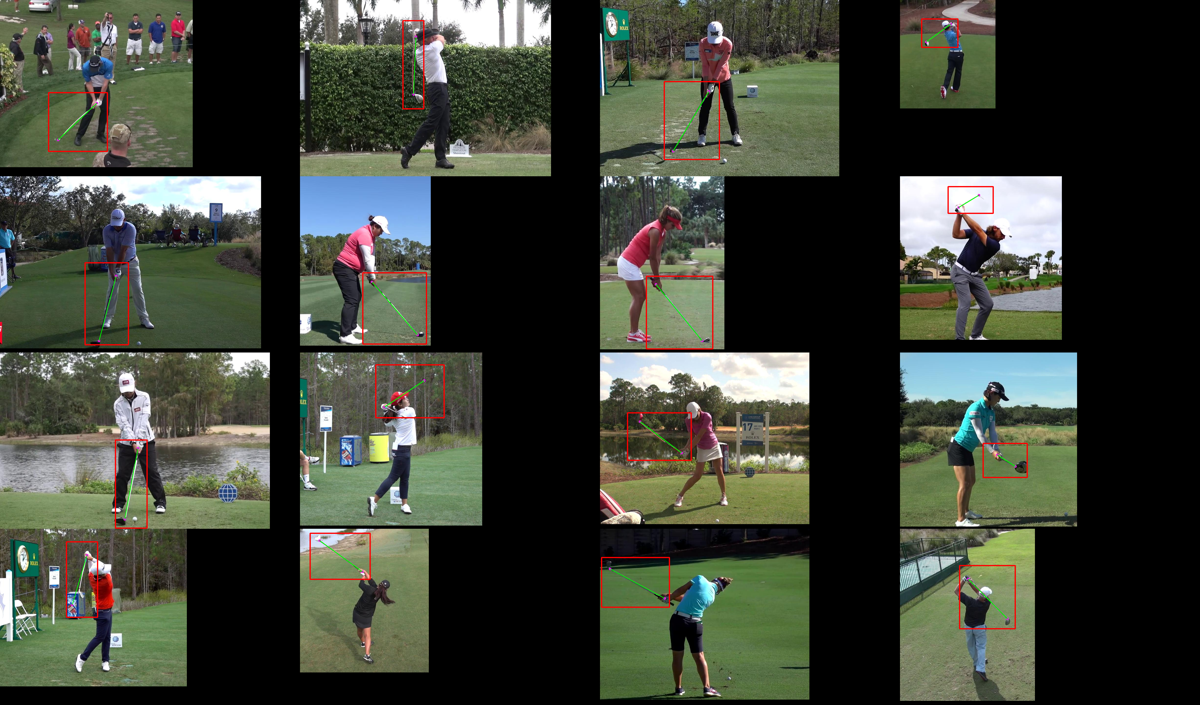

In [16]:
display(ImageOps.contain(Image.fromarray(generate_grid_predictions(loaded_model, test_dataloader, imgs_to_generate=16)), (1200, 1200)))

In [105]:
torch.cuda.empty_cache()

In [106]:
model = loaded_model

box_diffs = []
keypoint_diffs = []
total_elements = 0

t_start = time.time()
model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        images = [img.to(device) for img in batch[0]]
        targets = [{key: d[key].to(device) for key in d.keys()} for d in batch[1]]
        preds = model(images)

        total_elements+=len(preds)
        for idx in range(len(preds)):
            predicted_boxes = preds[idx]['boxes']
            predicted_clubs = preds[idx]['keypoints']
            if len(predicted_boxes) > 0:
                real_box = targets[idx]['boxes'][0]
                box_diffs.append(torch.abs(predicted_boxes[0] - real_box))

            if len(predicted_clubs) > 0:
                real_keypoints = targets[idx]['keypoints'][0]
                keypoint_diffs.append(torch.abs(predicted_clubs[0] - real_keypoints)[:,:2])

model.train()

stacked_boxes = torch.stack(box_diffs,dim=0).cpu().numpy()
stacked_keypoints = torch.stack(keypoint_diffs,dim=0).cpu().numpy()
club_errors = np.mean(stacked_keypoints, axis=2)

boxes_errors = np.mean(stacked_boxes, axis=1)
grip_errors = club_errors[:, 0]
head_errors = club_errors[:, 1]

print(f"Errors | bbox: {boxes_errors.mean():.2f}, grip: {grip_errors.mean():.2f}, head: {head_errors.mean():.2f}")

Errors | bbox: 12.61, grip: 4.11, head: 10.42


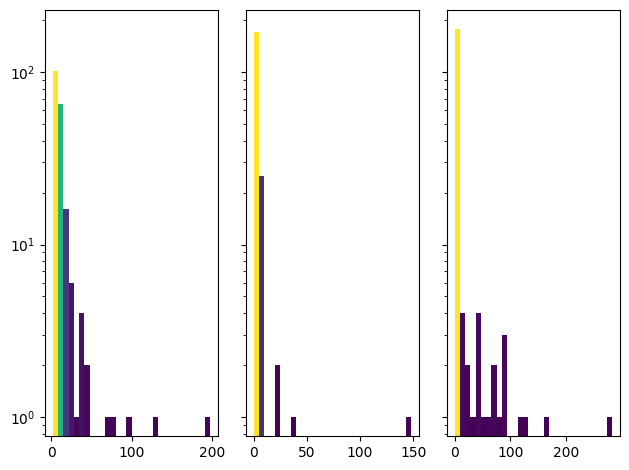

In [107]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

n_bins = 30

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
plt.yscale('log')

for idx, error in enumerate([boxes_errors, grip_errors, head_errors]):
    # N is the count in each bin, bins is the lower-limit of the bin
    N, bins, patches = axs[idx].hist(error, bins=n_bins)
    # We'll color code by height, but you could use any scalar
    fracs = N / N.max()
    # we need to normalize the data to 0..1 for the full range of the colormap
    norm = colors.Normalize(fracs.min(), fracs.max())
    # Now, we'll loop through our objects and set the color of each accordingly
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

plt.show()

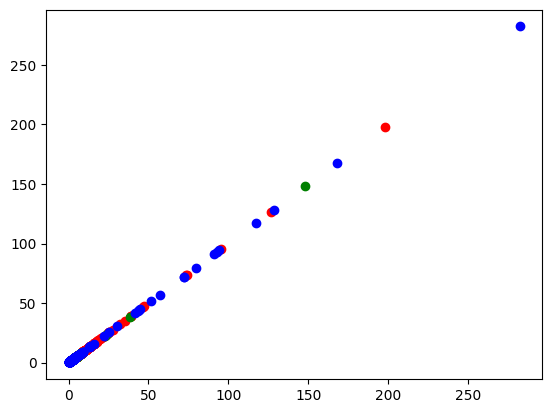

In [108]:
plt.plot(boxes_errors, boxes_errors, 'o', color='red')
plt.plot(grip_errors, grip_errors, 'o', color='green')
plt.plot(head_errors, head_errors, 'o', color='blue')
plt.show()

In [127]:
torch.cuda.empty_cache()

In [115]:
worst_n_samples = 16

boxes_idx = np.argpartition(boxes_errors, -worst_n_samples)[-worst_n_samples:]
grip_idx = np.argpartition(grip_errors, -worst_n_samples)[-worst_n_samples:]
head_idx = np.argpartition(head_errors, -worst_n_samples)[-worst_n_samples:]
boxes_idx, boxes_errors[boxes_idx]


(array([137,   7,   1,  96, 135,  27, 187,  98, 123,  72, 134,  89, 111,
        169,  19, 171]),
 array([ 24.74936 ,  25.383251,  25.413902,  27.631042,  32.42244 ,
         35.297188,  46.800488,  95.700584,  39.14678 ,  73.951096,
        126.68123 ,  39.235798,  47.393333,  73.47929 ,  38.94999 ,
        197.93326 ], dtype=float32))

In [117]:
worst_boxes = []
worst_grips = []
worse_heads = []
model.eval()
image_idx = 0
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        preds = model([img.to(device) for img in batch[0]])
        for tensor_img, pred_labels in zip(batch[0], preds):
            img = pad_img(tensor_to_pil(tensor_img))
            try:
                img = label_img(img, pred_labels)
            except Exception as e:
                print(f"Skipping img | {e}")

            if image_idx in boxes_idx:
                worst_boxes.append([boxes_errors[image_idx], img])

            if image_idx in grip_idx:
                worst_grips.append([grip_errors[image_idx], img])

            if image_idx in head_idx:
                worse_heads.append([head_errors[image_idx], img])

            image_idx+=1

In [134]:
worst_boxes = sorted(worst_boxes, key=lambda x: x[0], reverse=True)
worst_grips = sorted(worst_grips, key=lambda x: x[0], reverse=True)
worst_heads = sorted(worse_heads, key=lambda x: x[0], reverse=True)
worst_boxes[0][0], worst_boxes[-1][0]

(197.93326, 24.74936)

197.93 | 126.68 | 95.70 | 73.95
73.48 | 47.39 | 46.80 | 39.24
39.15 | 38.95 | 35.30 | 32.42
27.63 | 25.41 | 25.38 | 24.75


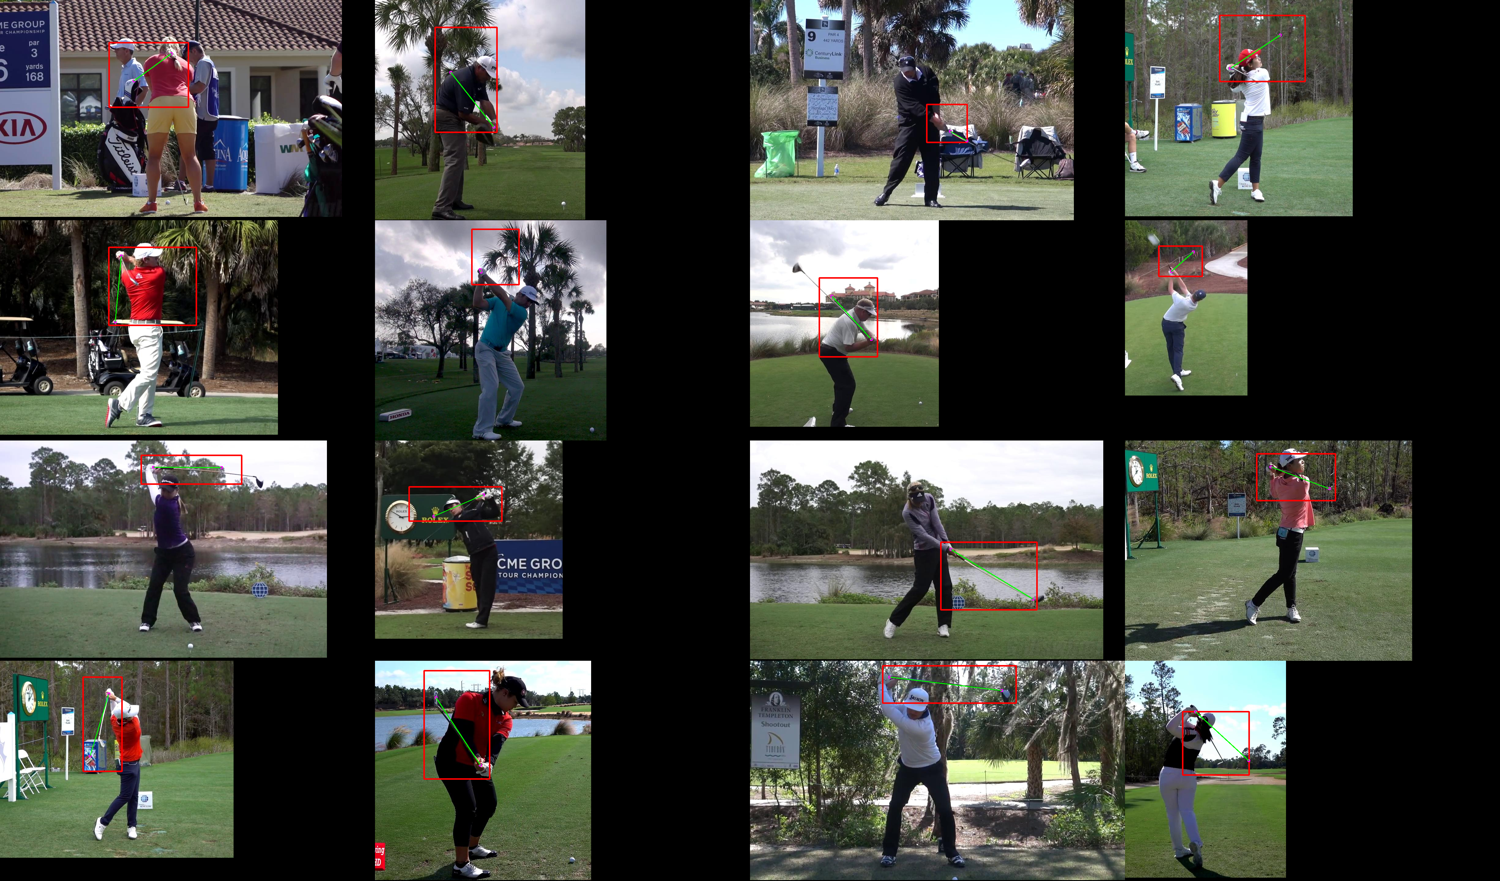

In [131]:
errors_strings = [str(f"{x[0]:.2f}") for x in worst_boxes]
print("Worst bboxes")
for i in range(4):
    print(' | '.join(errors_strings[i*4:(i+1)*4]))

img_preds_grid = generate_grid_from_pil([x[1] for x in worst_boxes], 4)
display(ImageOps.contain(Image.fromarray(img_preds_grid), (1500, 1500)))

Worst grips
147.92 | 38.53 | 23.80 | 22.67
8.82 | 8.09 | 8.06 | 7.97
7.86 | 7.81 | 7.76 | 7.52
7.35 | 7.14 | 7.07 | 6.91


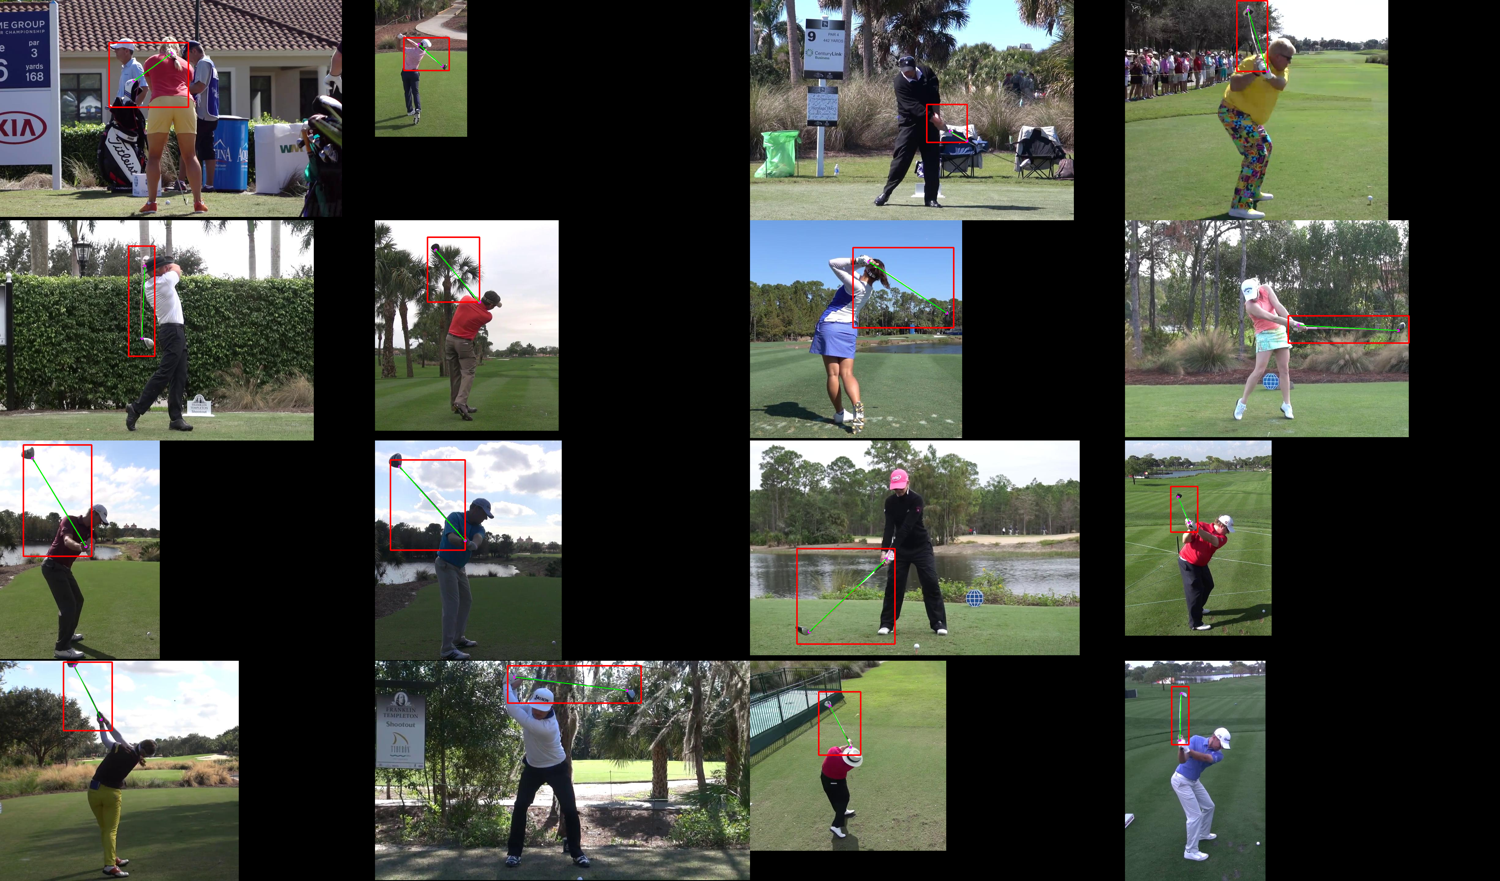

In [132]:
errors_strings = [str(f"{x[0]:.2f}") for x in worst_grips]
print("Worst grips")
for i in range(4):
    print(' | '.join(errors_strings[i*4:(i+1)*4]))

img_preds_grid = generate_grid_from_pil([x[1] for x in worst_grips], 4)
display(ImageOps.contain(Image.fromarray(img_preds_grid), (1500, 1500)))

Worst heads
282.30 | 167.91 | 128.49 | 117.15
94.14 | 93.07 | 91.22 | 79.58
72.27 | 72.08 | 57.09 | 51.84
44.62 | 43.84 | 43.20 | 41.72


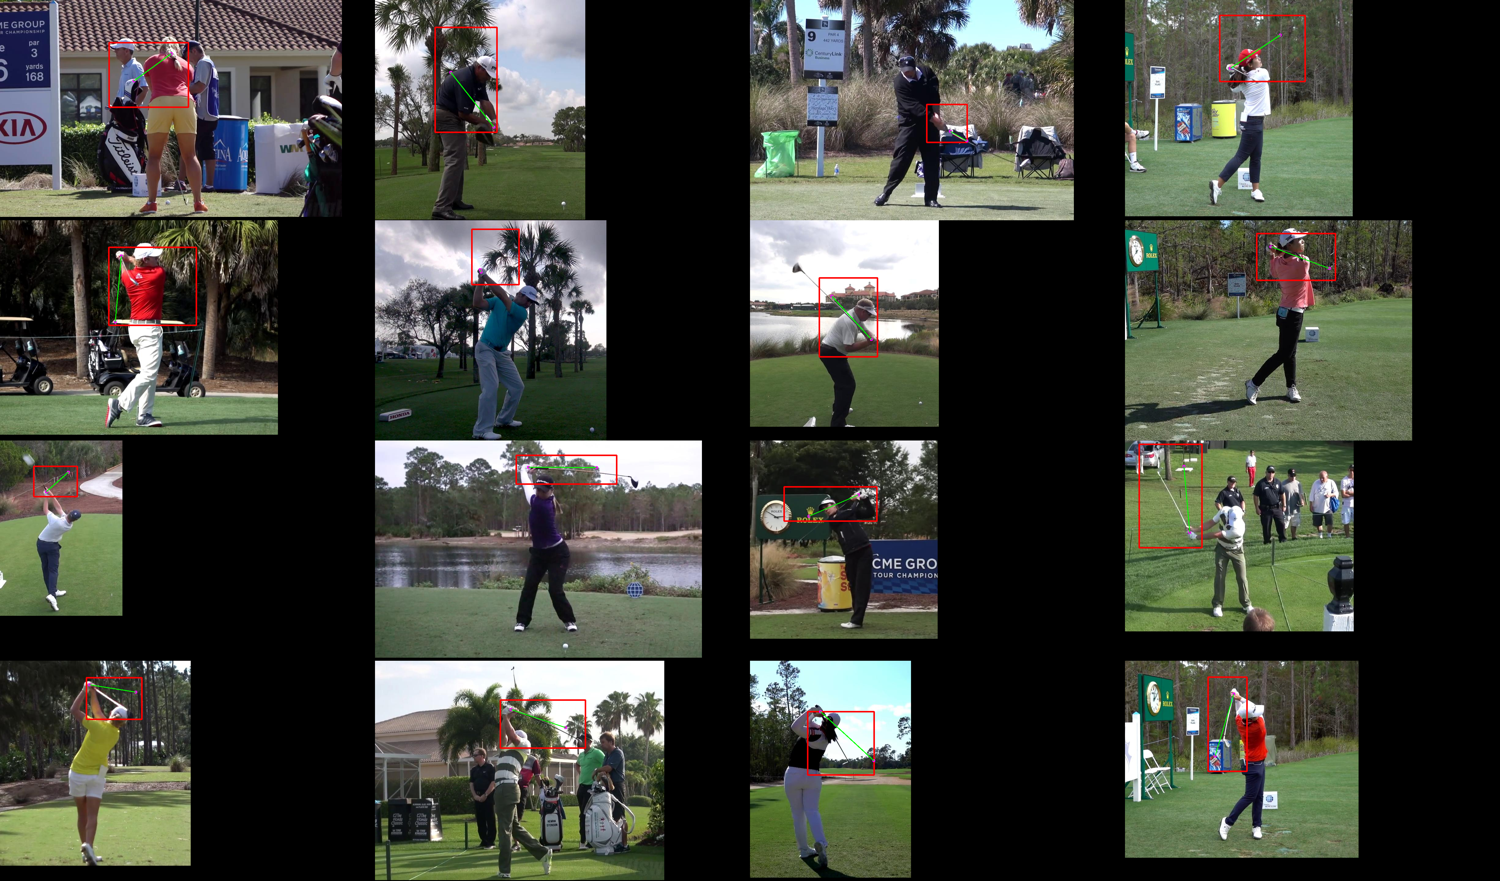

In [135]:
errors_strings = [str(f"{x[0]:.2f}") for x in worst_heads]
print("Worst heads")
for i in range(4):
    print(' | '.join(errors_strings[i*4:(i+1)*4]))

img_preds_grid = generate_grid_from_pil([x[1] for x in worst_heads], 4)
display(ImageOps.contain(Image.fromarray(img_preds_grid), (1500, 1500)))

In [136]:
print(f"Errors | bbox: {boxes_errors.mean():.2f}, grip: {grip_errors.mean():.2f}, head: {head_errors.mean():.2f}")

#grips -147.7 -> ~3.5
#heads -282 -167 -> ~8

#1st image hands aren't shown, and background golf clubs shown

Errors | bbox: 12.61, grip: 4.11, head: 10.42
